In [1]:
# Syntax error being tracked here: https://github.com/microsoft/vscode-jupyter/issues/6635
# If it's annoying, workaround here: https://stackoverflow.com/a/35597119/768439
%reload_ext autoreload
%autoreload 2

# TODO: Use this to profile: https://stackoverflow.com/questions/45893768/how-do-i-find-out-what-parts-of-my-code-are-inefficient-in-python
%load_ext line_profiler

In [2]:
import sys
sys.path.append('../')

from src.serialization_lib import *
from src.data_types import *

import matplotlib.dates as mdates
import datetime
import math
from collections import defaultdict
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = "{:,.2f}".format

In [3]:
INITIAL_PORTFOLIO_VALUE = 10000

BASE_METRIC = EvaluationMetric.EV_EBIT
TEST_METRIC = EvaluationMetric.P_B
STOCKS_UNIVERSE = StockUniverse.LARGE
PORTFOLIO_WEIGHT_STRATEGY = StockBasketWeightApproach.EQUAL_WEIGHTING

# DATA_BASE_PATH = '/Volumes/SDCard/TipBackTest/'
DATA_BASE_PATH = '/Users/olshansky/workspace/personal/'
DATA_PROCESSED_BASE_PATH = os.path.join(DATA_BASE_PATH, 'processed_data')
DATA_RESULT_BASE_PATH = os.path.join(DATA_BASE_PATH, 'results')

DEVELOPMENT = False
env = 'dev' if DEVELOPMENT else 'prod'

In [4]:
all_df_results = defaultdict(lambda: defaultdict(pd.DataFrame))
# all_rebalance_days = [30, 90, 180, 360, 730, 1825]
all_rebalance_days = [90, 180, 365, 730, 1825]
all_portfolio_sizes = [5, 10, 15, 30, 60]

for rebalance_days in all_rebalance_days:
    for portfolio_size in all_portfolio_sizes:
        filename = get_feather_filename('df_res', BASE_METRIC, TEST_METRIC, rebalance_days, portfolio_size, STOCKS_UNIVERSE, env)
        filename = os.path.join(DATA_PROCESSED_BASE_PATH, filename)
        # TODO: Need to fix the source code that generates these dataframes
        try:
            df = read_df_from_feather(filename)
        except Exception as e:
            print(f'Could not read df for {rebalance_days} rebalance with a portfolio size of {portfolio_size}')
            print(e)
            continue
        df.rename(columns={'index': 'date'}, inplace=True)
        df.set_index('date', inplace=True)
        
        all_df_results[rebalance_days][portfolio_size] = df


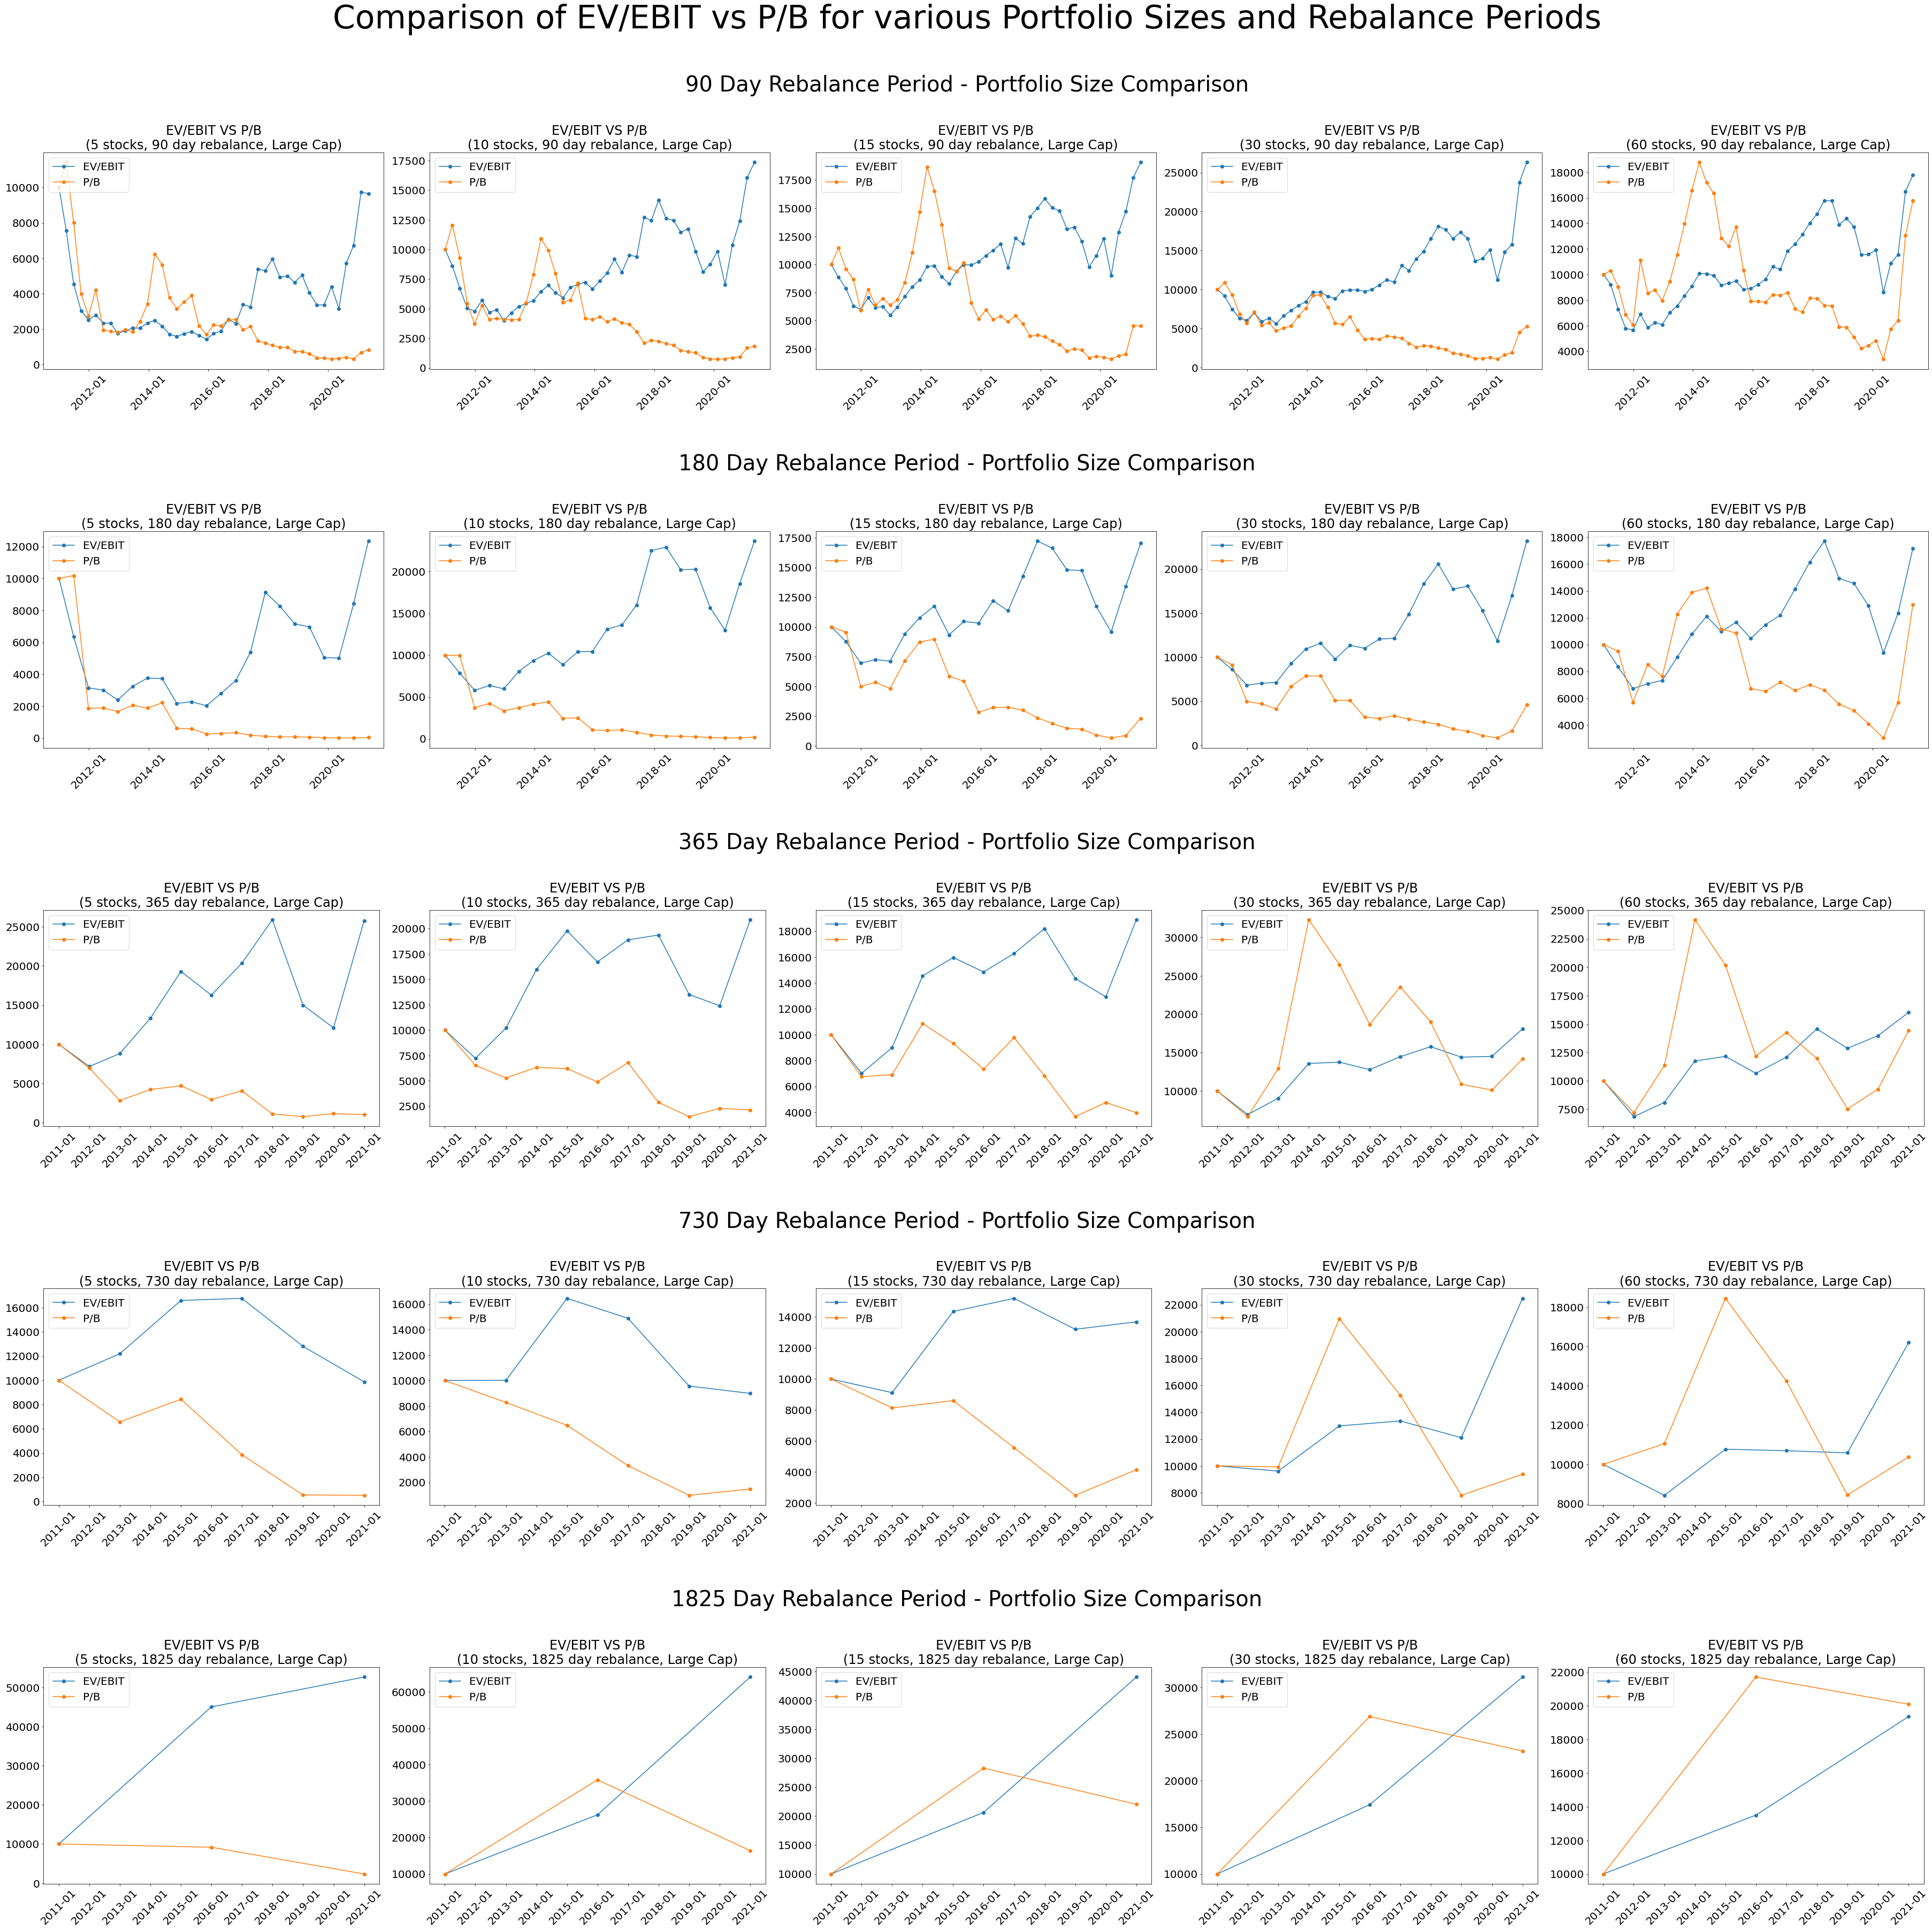

In [5]:
def plot_backtest(
    df: pd.DataFrame,
    base_metric: EvaluationMetric,
    test_metric: EvaluationMetric, 
    rebalance_days: int,
    portfolio_size: int,
    stocks_universe: StockUniverse,
    ax: plt.Axes,
) -> None:
    ax.set(title=(
        f'{str(base_metric)} VS {str(test_metric)}\n'
        f'({portfolio_size} stocks, {rebalance_days} day rebalance, {stocks_universe.human_readable()})')) 
    ax.plot(df.index, df['base_price'], label=str(base_metric), marker='o')
    ax.plot(df.index, df['test_price'], label=str(test_metric), marker='o')

    ax.legend(loc='upper left')
    ax.tick_params('x', labelrotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d'))

num_rows = len(all_rebalance_days)
num_cols = len(all_portfolio_sizes)

FIGURE_WIDTH = 50
FIGURE_HEIGHT = FIGURE_WIDTH / num_cols * num_rows

plt.rcParams["font.size"] = "20"

fig = plt.figure(
    constrained_layout=True,
    figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
fig.suptitle(f'Comparison of {str(BASE_METRIC)} vs {str(TEST_METRIC)} for various Portfolio Sizes and Rebalance Periods\n', fontsize=60)

subfigs = fig.subfigures(nrows=num_rows, ncols=1, hspace=0.1)
for row, (rebalance_days, subfig) in enumerate(zip(all_rebalance_days, subfigs)):
    subfig.suptitle(f'{rebalance_days} Day Rebalance Period - Portfolio Size Comparison\n', fontsize=40)
    axes = subfig.subplots(nrows=1, ncols=num_cols)
    for col, portfolio_size in enumerate(all_portfolio_sizes):
        plot_backtest(all_df_results[rebalance_days][portfolio_size], BASE_METRIC, TEST_METRIC, rebalance_days, portfolio_size, STOCKS_UNIVERSE, axes[col])

fig.savefig(os.path.join(DATA_RESULT_BASE_PATH, f'base_vs_test_comparison'), facecolor='white')

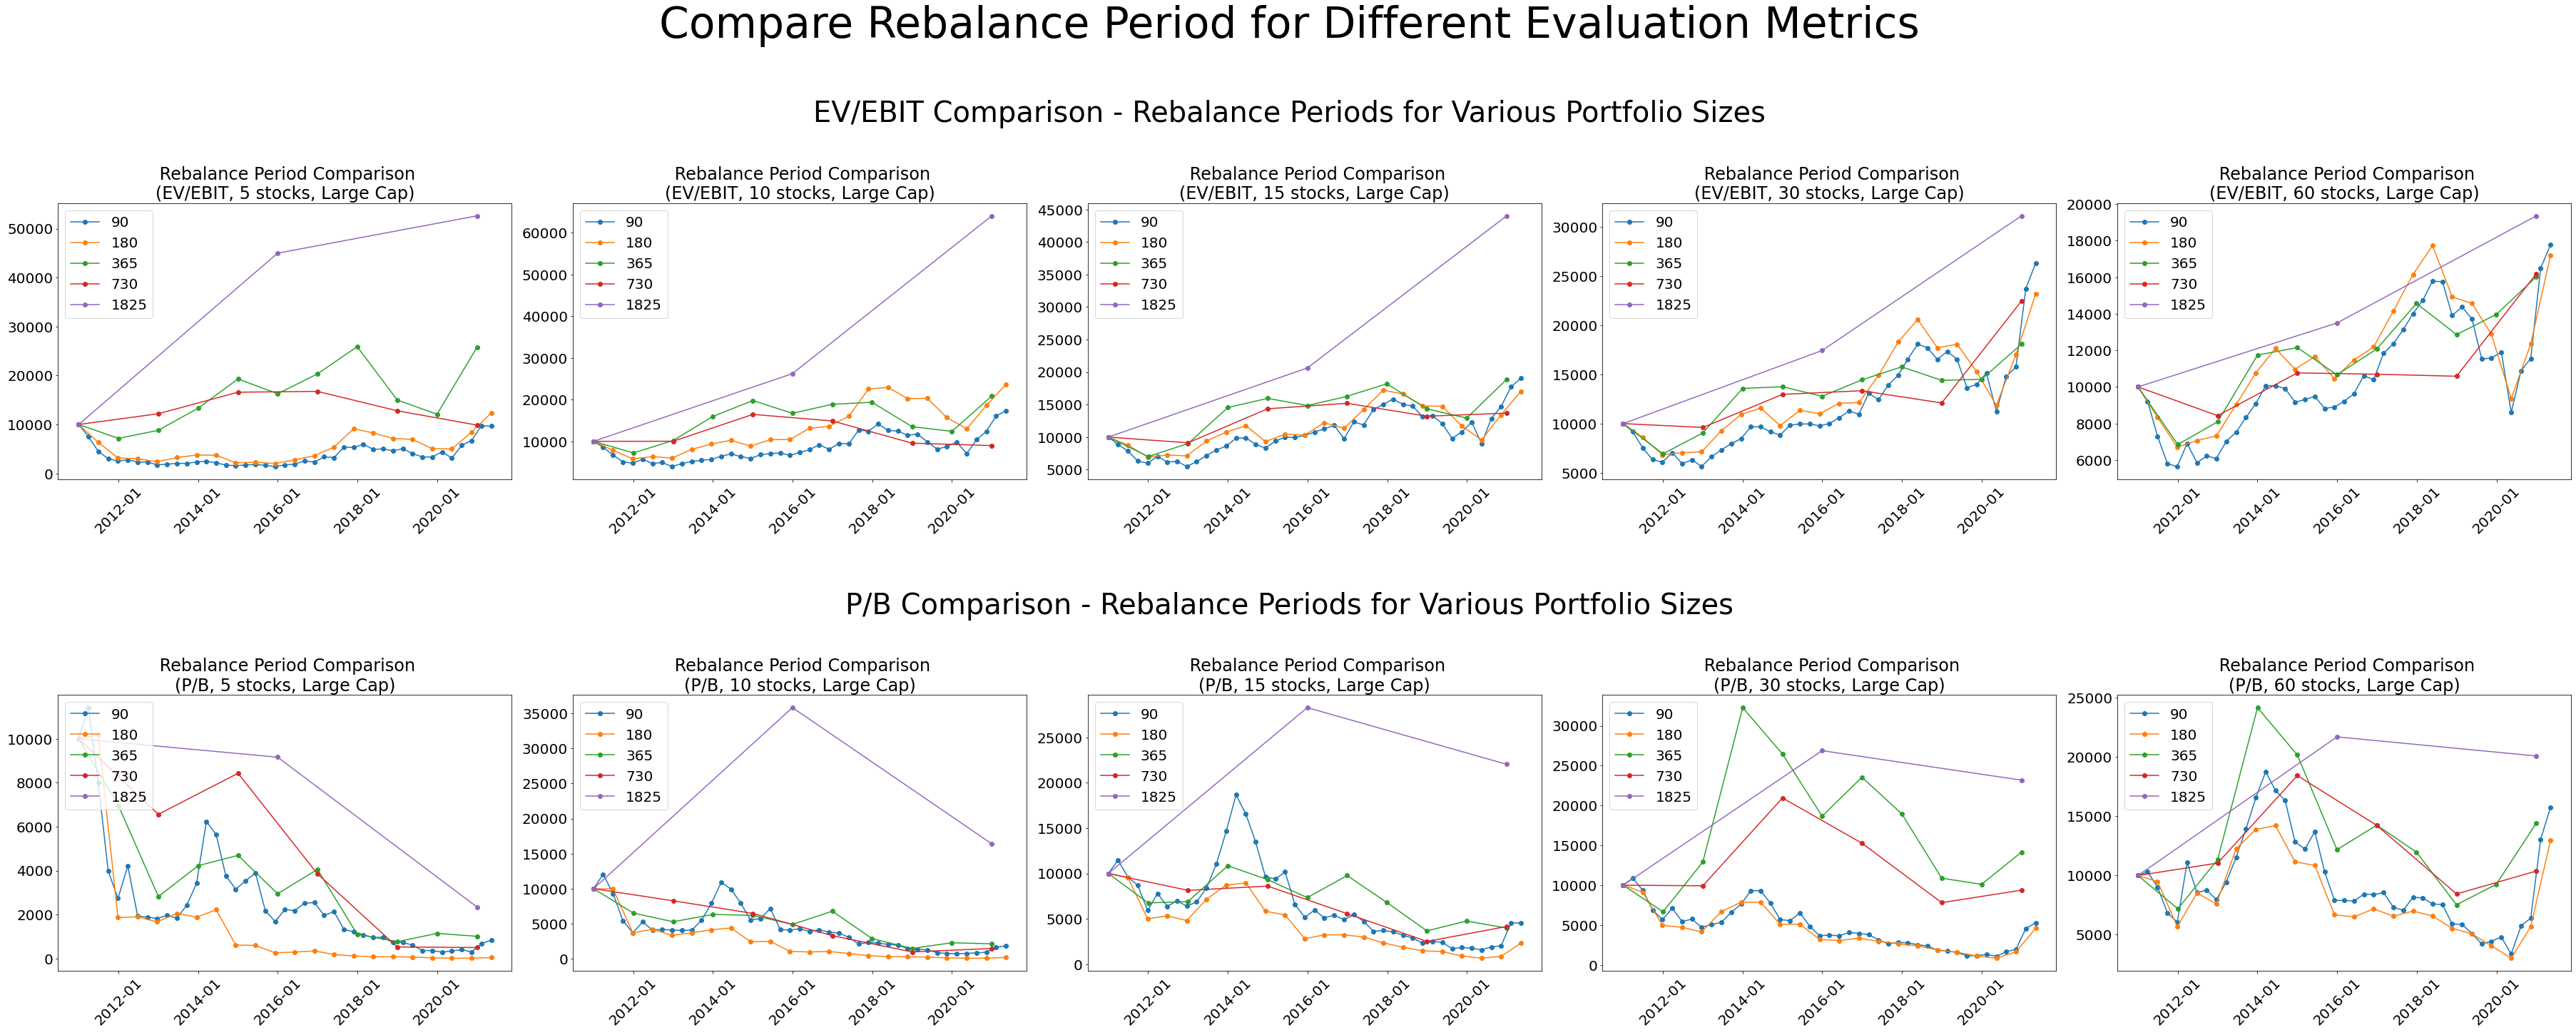

In [6]:
# For a specific portfolio size, plot performance of different rebalance days.

def plot_rebalance_days_investigation(
    df: pd.DataFrame,
    metric: EvaluationMetric,
    portfolio_size: int,
    all_rebalance_days: List[int],
    stocks_universe: StockUniverse,
    ax: plt.Axes,
) -> None:
    ax.set(title=(
        f' Rebalance Period Comparison\n'
        f'({str(metric)}, {portfolio_size} stocks, {stocks_universe.human_readable()})')) 

    for rebalance_days in all_rebalance_days:
        series = df[f'price_{rebalance_days}']
        mask = ~np.isnan(series)
        ax.plot(df.index[mask], series[mask], marker='o', label=rebalance_days) 
    
    ax.legend(loc='upper left')
    ax.tick_params('x', labelrotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d'))

# Hacky workaround because of how I preprocessed the data on a pairwise comparison.
def _get_price_key(metric: EvaluationMetric):
    if metric == EvaluationMetric.EV_EBIT:
        return 'base_price'
    elif metric == EvaluationMetric.P_B:
        return 'test_price'
    else:
        raise Exception("Price key not supported yet") 



metrics = [BASE_METRIC, TEST_METRIC]
num_rows = len(metrics)
num_cols = len(all_portfolio_sizes)

FIGURE_WIDTH = 50
FIGURE_HEIGHT = FIGURE_WIDTH / num_cols * num_rows

plt.rcParams["font.size"] = "20"    

fig = plt.figure(constrained_layout=True, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
fig.suptitle('Compare Rebalance Period for Different Evaluation Metrics\n', fontsize=60)

subfigs = fig.subfigures(nrows=num_rows, ncols=1, hspace=0.1)
for row, (metric, subfig) in enumerate(zip(metrics, subfigs)):
    subfig.suptitle(f'{str(metric)} Comparison - Rebalance Periods for Various Portfolio Sizes\n', fontsize=40)
    axes = subfig.subplots(nrows=1, ncols=num_cols)
    price_key = _get_price_key(metric)
    for col, portfolio_size in enumerate(all_portfolio_sizes):
        df_to_plot = pd.DataFrame(columns=['date'])
        for rebalance_days in all_rebalance_days:
            df = all_df_results[rebalance_days][portfolio_size].reset_index()
            prices = df[['date', price_key]].rename(columns={price_key: f'price_{rebalance_days}'})
            df_to_plot = df_to_plot.merge(prices, how='outer', on='date')
        df_to_plot = df_to_plot.set_index('date').sort_index()
        plot_rebalance_days_investigation(df_to_plot, metric, portfolio_size, all_rebalance_days, STOCKS_UNIVERSE, axes[col])

fig.savefig(os.path.join(DATA_RESULT_BASE_PATH, f'portfolio_comparison'), facecolor='white')

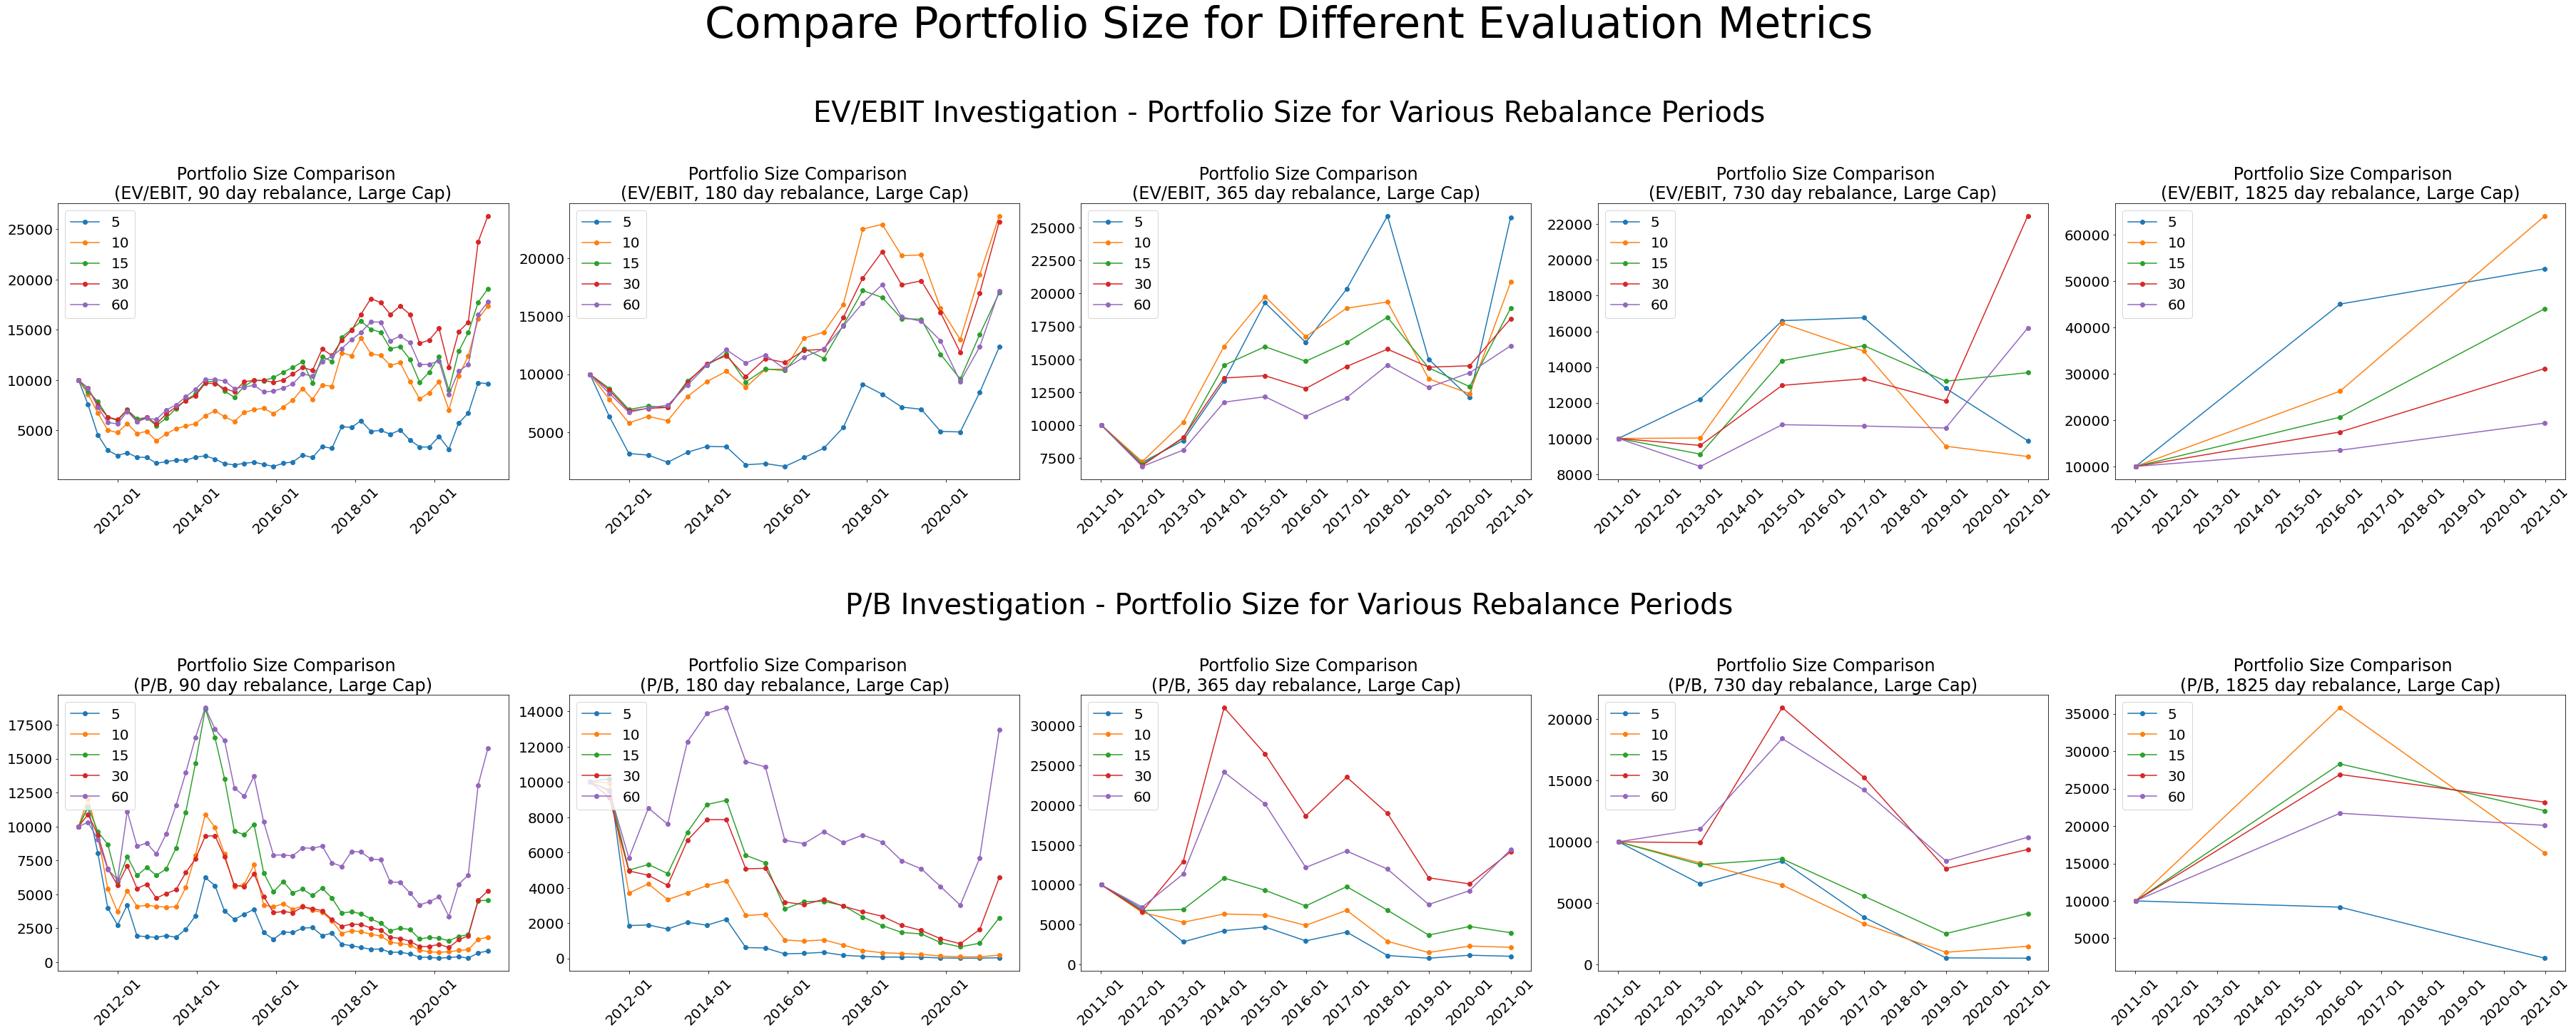

In [7]:
# For a specific portfolio size, plot performance of different rebalance days.

def plot_rebalance_days_investigation(
    df: pd.DataFrame,
    metric: EvaluationMetric,
    rebalance_days: int,
    all_portfolio_sizes: List[int],
    stocks_universe: StockUniverse,
    ax: plt.Axes,
) -> None:
    ax.set(title=(
        f' Portfolio Size Comparison\n'
        f'({str(metric)}, {rebalance_days} day rebalance, {stocks_universe.human_readable()})')) 

    for portfolio_size in all_portfolio_sizes:
        series = df[f'price_{portfolio_size}']
        mask = ~np.isnan(series)
        ax.plot(df.index[mask], series[mask], marker='o', label=portfolio_size) 
    
    ax.legend(loc='upper left')
    ax.tick_params('x', labelrotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d'))

metrics = [BASE_METRIC, TEST_METRIC]
num_rows = len(metrics)
num_cols = len(all_rebalance_days)

FIGURE_WIDTH = 50
FIGURE_HEIGHT = FIGURE_WIDTH / num_cols * num_rows

plt.rcParams["font.size"] = "20"    

fig = plt.figure(constrained_layout=True, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
fig.suptitle('Compare Portfolio Size for Different Evaluation Metrics\n', fontsize=60)

subfigs = fig.subfigures(nrows=num_rows, ncols=1, hspace=0.1)
for row, (metric, subfig) in enumerate(zip(metrics, subfigs)):
    price_key = _get_price_key(metric)
    subfig.suptitle(f'{str(metric)} Investigation - Portfolio Size for Various Rebalance Periods\n', fontsize=40)
    axes = subfig.subplots(nrows=1, ncols=num_cols)
    for col, rebalance_days in enumerate(all_rebalance_days):
        df_to_plot = pd.DataFrame(columns=['date'])
        for portfolio_size in all_portfolio_sizes:
            df = all_df_results[rebalance_days][portfolio_size].reset_index()
            prices = df[['date', price_key]].rename(columns={price_key: f'price_{portfolio_size}'})
            df_to_plot = df_to_plot.merge(prices, how='outer', on='date')
        df_to_plot = df_to_plot.set_index('date').sort_index()
        plot_rebalance_days_investigation(df_to_plot, metric, rebalance_days, all_portfolio_sizes, STOCKS_UNIVERSE, axes[col])

fig.savefig(os.path.join(DATA_RESULT_BASE_PATH, f'rebalance_comparison'), facecolor='white')